## Analyze whether SNWD varies more from year to year or from place to place.

In [1]:
import pandas as pd
import numpy as np
import urllib
import math

In [2]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [3]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [4]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BBBSBBBB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
823
+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|           coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|          res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+-----------+------+--------------------+------+
|3444.5136211368026|-334.2586807643685|-372.0405482878972|    332.2|BBBSBBBB| 42.5333| -72.1833|       SNWD|0.07179544199492165|0.06330051275611745|0.05260064778837763|0.656690062661369

In [6]:
print df.columns

['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'label', 'latitude', 'longitude', 'measurement', 'res_1', 'res_2', 'res_3', 'res_mean', 'station', 'total_var', 'undefs', 'vector', 'year']


In [25]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
#Features=', '.join(['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'latitude', 'longitude',\
#          'res_1', 'res_2', 'res_3', 'res_mean', 'year'])
Features='station, year, coeff_2'
Query="SELECT %s FROM weather"%Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_2 FROM weather


station    year      coeff_2
0  USC00196322  1987.0  -334.258681
1  USC00196783  1969.0  2484.242555
2  USC00199360  1948.0 -2460.750314
3  USC00192806  1971.0    59.818230
4  USW00014753  1969.0  3172.996640

In [40]:
year_station_table=pdf.pivot(index='year', columns='station', values='coeff_2')
year_station_table.tail(10)

station  USC00190120  USC00190166  USC00190408  USC00190535  USC00190562  \
year                                                                       
2002.0           NaN          NaN  -158.176019          NaN          NaN   
2003.0   -249.507634          NaN    68.030422  -315.317173          NaN   
2004.0     89.467059          NaN   -51.695401          NaN    24.785991   
2005.0      7.315666          NaN   -92.096124  -170.773921    53.769423   
2007.0    516.814755          NaN   474.581920   525.515062   532.351136   
2008.0   -154.988867          NaN          NaN   -16.088447  -108.176674   
2009.0   -439.154299          NaN          NaN          NaN          NaN   
2010.0           NaN          NaN          NaN          NaN          NaN   
2011.0           NaN          NaN          NaN          NaN          NaN   
2012.0           NaN          NaN          NaN          NaN          NaN   

station  USC00190593  USC00190998  USC00191323  USC00191344  USC00191622  \
year                                                                       
2002.0           NaN          NaN          NaN          NaN          NaN   
2003.0    384.343099          NaN          NaN          NaN          NaN   
2004.0           NaN          NaN          NaN          NaN          NaN   
2005.0   1083.098986          NaN          NaN          NaN          NaN   
2007.0           NaN          NaN          NaN          NaN          NaN   
2008.0           NaN          NaN          NaN          NaN          NaN   
2009.0           NaN          NaN          NaN          NaN          NaN   
2010.0           NaN          NaN          NaN          NaN          NaN   
2011.0           NaN          NaN          NaN          NaN          NaN   
2012.0           NaN          NaN          NaN          NaN          NaN   

station     ...       USC00199928  USW00004769  USW00004779  USW00014702  \
year        ...                                                            
2002.0      ...               NaN          NaN          NaN          NaN   
2003.0      ...               NaN          NaN          NaN          NaN   
2004.0      ...               NaN          NaN          NaN          NaN   
2005.0      ...               NaN          NaN          NaN          NaN   
2007.0      ...               NaN          NaN          NaN          NaN   
2008.0      ...               NaN          NaN          NaN          NaN   
2009.0      ...               NaN          NaN          NaN          NaN   
2010.0      ...               NaN          NaN          NaN          NaN   
2011.0      ...               NaN          NaN          NaN          NaN   
2012.0      ...               NaN          NaN          NaN          NaN   

station  USW00014703  USW00014739  USW00014753  USW00014790  USW00094701  \
year                                                                       
2002.0           NaN          NaN          NaN          NaN          NaN   
2003.0           NaN          NaN   319.637180          NaN          NaN   
2004.0           NaN          NaN          NaN          NaN          NaN   
2005.0           NaN          NaN    49.623896          NaN          NaN   
2007.0           NaN          NaN          NaN          NaN          NaN   
2008.0           NaN          NaN    14.051392          NaN          NaN   
2009.0           NaN          NaN  -901.381894          NaN          NaN   
2010.0           NaN          NaN  -172.976479          NaN          NaN   
2011.0           NaN          NaN -1255.525436          NaN          NaN   
2012.0           NaN          NaN          NaN          NaN          NaN   

station  USW00094746  
year                  
2002.0           NaN  
2003.0           NaN  
2004.0           NaN  
2005.0           NaN  
2007.0           NaN  
2008.0           NaN  
2009.0           NaN  
2010.0           NaN  
2011.0           NaN  
2012.0           NaN  

[10 rows x 57 columns]

In [43]:
#year_station_array=np.array(year_station_table)
#type(year_station_array)

numpy.ndarray

In [65]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print 'total RMS                   = ',RMS(year_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-year   = ',RMS(tbl_minus_year)

total RMS                   =  652.312384947
RMS removing mean-by-station=  641.899529734
RMS removing mean-by-year   =  281.698896841


In [68]:
T=year_station_table
print 'initial RMS=',RMS(T)
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print i,'after removing mean by year    =',RMS(T)
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print i,'after removing mean by stations=',RMS(T)

initial RMS= 652.312384947
0 after removing mean by year    = 281.698896841
0 after removing mean by stations= 268.442877822
1 after removing mean by year    = 267.084176624
1 after removing mean by stations= 266.678831215
2 after removing mean by year    = 266.510870048
2 after removing mean by stations= 266.431313173
3 after removing mean by year    = 266.390236857
3 after removing mean by stations= 266.367238732
4 after removing mean by year    = 266.353175433
4 after removing mean by stations= 266.343730149


In [142]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#73ff83'

## Map

In [143]:
min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)


In [144]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

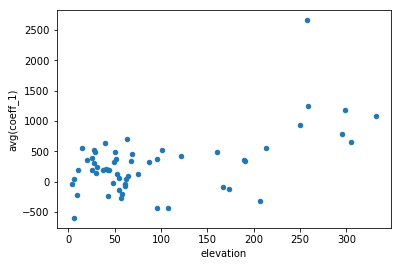

In [148]:
pdf.plot.scatter(x='elevation',y=_avg)